## Fetal lung B cell development 
<br>
<b>Description</b> : In this notebook we use the cell-cell interaction output (beta) of fetal lung datasets to obtain the spearson coefficient between the beta and gene expressions for the marker genes (Figure 5e of the manuscript).<br>
<b>Author</b> : Hejin Huang (huang.hejin@gene.com)<br>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from scipy.stats import spearmanr

In [2]:
folder_ID = '../../data/analysis/fetal_lung/B_development'

# Load annotated single-cell data
ad_sc_all = sc.read_h5ad('../../data/original/fetallung/sc'
                     '220715Annotated_Fetal_lung_immune_filtered_soupxcite_cxg.h5ad')

# Normalize and log-transform the data
sc.pp.normalize_total(ad_sc_all, target_sum=1E4)
sc.pp.log1p(ad_sc_all)

In [3]:
# --- Define Cell Types and Markers ---

B_split = ['HSC/MPP', 'LMPP/ELP', 'Pre-pro-B',  'Pro-B', 'Late pro-B', 'Pro-B/Pre-B transition','Large pre-B', 'κ small pre-B', 'λ small pre-B', 
          'Late pre-B','Immature B', 'CD5+ Mature B', 'CD5- Mature B'] # 

B_marker = ['CD34', 'EBF1', 'SPINK2','VPREB1', 'DNTT', 'NEIL1', 'RAG1', 'MS4A1', 'IL7R', 'MKI67','SPIB', 'IGKC', 'IGLC2', 'IGLC3',
            'IGLL1','IGHD','IGHM','VPREB3', 'BEST3', 'CD5','CD27', 'SPN', 'CCR10', 'CCL22', 'PRDM1']

In [4]:
# --- Calculate Fraction and Expression ---

B_fraction_df = pd.DataFrame(index=B_split, columns=B_marker)
B_expression_df = pd.DataFrame(index=B_split, columns=B_marker)

# Populate dataframes with fraction and expression
# This loop iterates through B_split (cell types) and B_marker (genes)
# For each cell type, it filters ad_sc_all to get a subset of cells belonging to that cell type.
# Then, for each gene in B_marker, it calculates:
# 1. The fraction of cells in the subset that express the gene (X != 0).
# 2. The mean expression of the gene in the subset (X).
for i in B_fraction_df.index: # Iterates through cell types
    # Get a subset of ad_sc_all for the current cell type
    cell_type_subset = ad_sc_all[ad_sc_all.obs.celltype == i]
    
    # Calculate fraction of cells expressing each marker for the current cell type
    # (cell_type_subset[:, B_marker].X != 0) creates a boolean array indicating expression
    # .sum(axis=0) counts expressing cells for each marker
    # / len(cell_type_subset) normalizes by total cells in the subset
    B_fraction_df.loc[i] = (cell_type_subset[:, B_marker].X != 0).sum(axis=0) / len(cell_type_subset)
    
    # Calculate mean expression of each marker for the current cell type
    # .mean(axis=0) computes the mean expression for each marker
    B_expression_df.loc[i] = cell_type_subset[:, B_marker].X.mean(axis=0)


In [10]:
celltype_list = list(set(ad_sc_all.obs.celltype.unique()) - set(B_split))
cleaned_list = [s.replace('/', '_') for s in celltype_list]


# Initialize DataFrame for Spearman correlation results
spearman_corr = pd.DataFrame(index=cleaned_list, columns=B_marker, dtype=float)

# Calculate Spearman correlation
for celltype in cleaned_list:
    # Read the comparison CSV file for the current cell type
    result = pd.read_csv(folder_ID + celltype + '.csv', index_col=0)
    
    # Iterate through each gene (column) in the spearman_corr DataFrame
    for gene in spearman_corr.columns:
        # Calculate Spearman correlation between 'result' data and 'B_expression_df' data
        # .loc[B_split, gene] selects rows corresponding to B_split cell types and the current gene
        # spearmanr returns (correlation_statistic, pvalue)
        res = spearmanr(result.loc[B_split, gene], B_expression_df.loc[B_split, gene])
        
        # Store only the correlation statistic in the spearman_corr DataFrame
        spearman_corr.loc[celltype, gene] = res.statistic

In [11]:
## reorder row based on median values
spearman_corr['median'] = spearman_corr.median(axis=1)
spearman_corr.sort_values(by='median', ascending=False, inplace=True)
spearman_corr.drop('median', axis=1, inplace=True)

<AxesSubplot: >

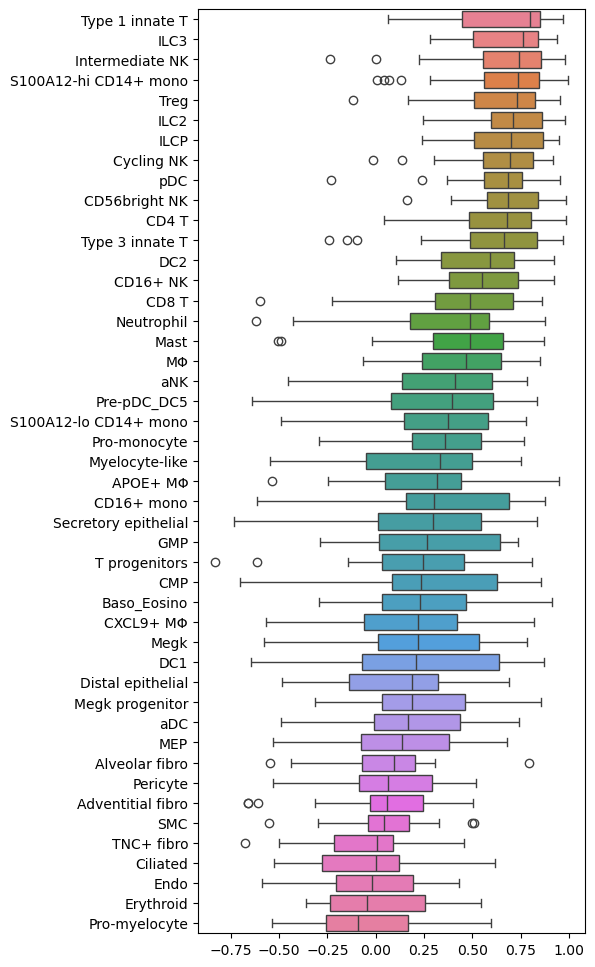

In [12]:
plt.figure(figsize=(5,12))
sns.boxplot(data=spearman_corr.T, orient="h",)